In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X = pd.read_csv('X.csv', header=None)
y = pd.read_csv('y.csv', header=None)

In [3]:
class Regressor:
    
    def __init__(self, rType='OLS', s=None):
        self.model = None
        self.rType = rType
        self.s = s
        return
    
    def foldConstant(self, train_data):
        a = np.ones(shape=(train_data.shape[0],(train_data.shape[1] + 1)))
        a[:,1:] = train_data.to_numpy()
        return a
    
    def fit(self, train_data, y):
        train_data = self.foldConstant(train_data) # fold the constant into X
        if self.rType == 'OLS':
            innerDot = np.dot(train_data.transpose(), train_data)
        elif self.rType == 'Ridge':
            innerDot = np.dot(train_data.transpose(), train_data)
            regTerm = (self.s **2) * np.identity(train_data.shape[1])
            innerDot = np.add(innerDot, regTerm)
        innerDotInverse = np.linalg.inv(innerDot)
        outerDot = np.dot(innerDotInverse, train_data.transpose())
        finalDot = np.dot(outerDot, y)
        self.model= finalDot
        return
    
    def predict(self, test_data):
        test_data = self.foldConstant(test_data)
        return np.dot(test_data, self.model)
    
    def getModel(self):
        return self.model

In [4]:
def estimateError(y, preds):
    return np.linalg.norm(np.subtract(y, preds))

In [5]:
# now we can solve for the coefficients alpha using OLS
ols_model = Regressor(rType='OLS')
ols_model.fit(X, y)

In [6]:
# now reporting the error of the estimate
ols_preds = ols_model.predict(X)
print("**OLS Error**")
print(estimateError(y, ols_preds))

alphas = pd.DataFrame(ols_model.getModel())
alphas = alphas.rename(columns={0:'OLS'})

# we can also solve for alpha using Ridge regression with different values S
for s in range(2,18,2):
    r_model = Regressor(rType='Ridge', s=s/10)
    r_model.fit(X, y)
    alphas['s'+str(s/10)] = r_model.getModel()
        
alphas.head()

**OLS Error**
3.4566296684750095


,OLS,s0.2,s0.4,s0.6,s0.8,s1.0,s1.2,s1.4,s1.6
0,-0.048955,-0.042409,-0.030717,-0.023488,-0.020366,-0.020138,-0.021741,-0.024400,-0.027580
1,-9.622454,0.228028,0.291355,0.235982,0.204878,0.190021,0.181357,0.174130,0.166660
2,6.969844,2.069162,1.555846,1.301439,1.113732,0.963994,0.841651,0.740130,0.654814
3,-3.998485,-0.465681,-0.270232,-0.265812,-0.275148,-0.276245,-0.268724,-0.255489,-0.239186
4,6.770697,1.149011,0.744397,0.586894,0.493259,0.427561,0.377276,0.336854,0.303297


In [7]:
# now lets run the experiment
def runExperiment(X, y, rType='OLS'):
    if rType is 'Ridge':
        sList=[]
        res=[]
        for s in range(2,18,2):
            model = Regressor(rType='Ridge', s=s/10)
            model.fit(X, y)
            preds = model.predict(X)
            sList.append(s/10)
            res.append(estimateError(y, preds))

        res_df = pd.DataFrame({'S': sList, 'Error':res})
        return res_df
    else:
        model = Regressor(rType='OLS')
        model.fit(X, y)
        return estimateError(y, model.predict(X))

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
res_df = runExperiment(X, y, rType='Ridge')

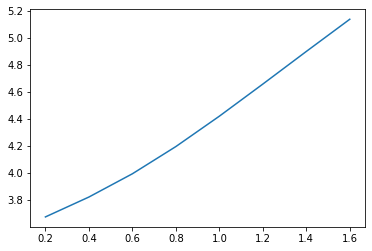

In [10]:
fig = plt.figure()
ax = plt.axes()

ax.plot(res_df.S, res_df.Error);

In [11]:
res_df

,S,Error
0,0.2,3.676513
1,0.4,3.823765
2,0.6,3.995933
3,0.8,4.197474
4,1.0,4.422363
5,1.2,4.660180
6,1.4,4.901718
7,1.6,5.140233


In [12]:
# a function for the cross validation described in question 1B
def crossValidate(X, y):
    trainXList = []
    trainYList = []
    testXList = []
    testYList = []

    trainXList.append(X.to_numpy()[:66])
    trainYList.append(y[:66])
    testXList.append(X.to_numpy()[66:])
    testYList.append(y[66:])

    trainXList.append(X.to_numpy()[33:])
    trainYList.append(y[33:])
    testXList.append(X.to_numpy()[:33])
    testYList.append(y[:33])

    trainXList.append(np.vstack((X[:33], X[66:])))
    trainYList.append(np.vstack((y[:33], y[66:])))
    testXList.append(X.to_numpy()[33:66])
    testYList.append(y[33:66])

    result = pd.DataFrame(['OLS', 's0.2', 's0.4',
                           's0.6', 's0.8', 's1.0',
                           's1.2', 's1.4', 's1.6'])

    for i in range(len(trainXList)):
        errList = []
        ols_model = Regressor(rType='OLS')
        ols_model.fit(pd.DataFrame(trainXList[i]), trainYList[i])
        ols_preds = ols_model.predict(pd.DataFrame(testXList[i]))
        errList.append(estimateError(testYList[i], ols_preds))

        for s in range(2,18,2):
            ridge_model = Regressor(rType='Ridge', s=s/10)
            ridge_model.fit(pd.DataFrame(trainXList[i]), trainYList[i])
            ridge_preds = ridge_model.predict(pd.DataFrame(testXList[i]))
            errList.append(estimateError(testYList[i], ridge_preds))

        result['Error'+str(i)] = errList
    result['Avg'] = (result.Error0 + result.Error1 + result.Error2) / 3
    result = result.rename(columns={0:'Model'})
    return result

In [13]:
crossValidate(X,y)

,Model,Error0,Error1,Error2,Avg
0,OLS,6.290761,4.937106,4.443744,5.223870
1,s0.2,4.094690,3.229181,3.276312,3.533394
2,s0.4,3.606376,3.083150,2.775584,3.155036
3,s0.6,3.432230,3.210792,2.539067,3.060696
4,s0.8,3.400994,3.388169,2.471685,3.086949
5,s1.0,3.435351,3.571457,2.502003,3.169604
6,s1.2,3.499165,3.747140,2.586945,3.277750
7,s1.4,3.575567,3.910420,2.700000,3.395329
8,s1.6,3.656301,4.059809,2.824578,3.513563
